In [2]:
import torch
from torch import nn
from matplotlib import pyplot as plt
import numpy
import os
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
if(not os.path.exists("helper_functions.py")):
  from requests import get
  req = get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py" , "wb") as f :
    f.write(req.content)
    f.close()
import helper_functions as hf

##DATA & BATCHES

In [3]:
train_data = datasets.FashionMNIST(
    root = "data",
    download = True,
    train = True,
    target_transform = None,
    transform = ToTensor()
)
test_data = datasets.FashionMNIST(
    root ="data",
    download = True,
    train =False,
    target_transform = None,
    transform = ToTensor()
)

100%|██████████| 26421880/26421880 [00:06<00:00, 3939375.93it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 210549.48it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3867269.30it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22077992.83it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
BatchSize = 32
trainDataLoader = DataLoader(batch_size = BatchSize , shuffle = True , dataset = train_data)
testDataLoader = DataLoader(batch_size = BatchSize , shuffle = False , dataset = test_data)

In [5]:
classNames = train_data.classes
classNames

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

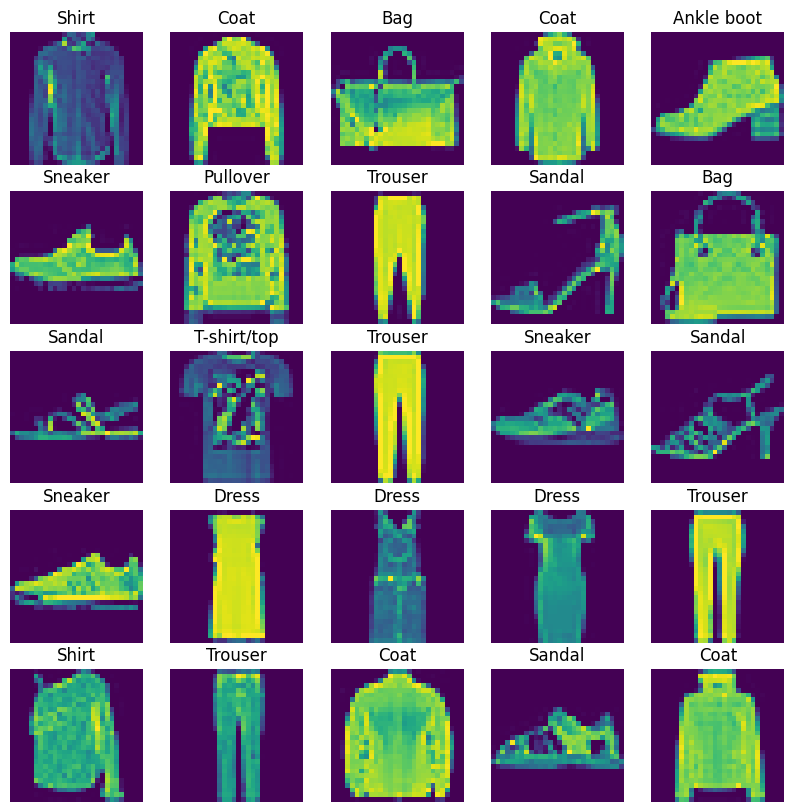

In [6]:
row , col = 5, 5
fig = plt.figure(figsize = (row*2 , col*2))

for i in range(1,row*col +1):
  fig.add_subplot(row,col,i)
  idx = torch.randint(0,len(train_data),size = [1]).item()
  img , label = train_data[idx]
  plt.imshow(img.permute(1,2,0))
  plt.title(classNames[label])
  plt.axis(False)


##Model Class Creation
one - fully linear no activation <br>
two - linear with activation of relu<br>
three - CNN model


In [7]:
class one(nn.Module):
  def __init__(self):
    super().__init__()
    self.seq = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = 28*28 , out_features = 10)
    )
  def forward(self , X):
    return self.seq(X)
  def pred(self , X):
    self.eval()
    with torch.inference_mode():
      return self(X)


In [8]:
model0 = one()
loss_fn = nn.CrossEntropyLoss()

In [9]:
def train(model:nn.Module = None, loss_fn =loss_fn ,lr = 0.1,epochs = 3, trainDataLoader=trainDataLoader  , testDataLoader = testDataLoader , batch_size = 32 ):
  optimizer = torch.optim.Adam(params = model.parameters() , lr = lr)
  from tqdm.auto import tqdm

  for epoch in tqdm(range(epochs)):
    model.train()
    iterLoss = 0
    for batch , (X,y) in enumerate(trainDataLoader):
      logits = model(X)
      loss = loss_fn(logits , y)
      iterLoss += loss
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if(batch % 400 == 0 ): print(f"seen {batch * batch_size} / {len(trainDataLoader)*batch_size}")
    overallLoss = iterLoss / len(trainDataLoader)

    model.eval()
    with torch.inference_mode():
      testLoss = 0
      testAcc = 0
      for batch , (X , y_test) in enumerate(testDataLoader):
        test_logits = model(X)
        test_loss = loss_fn(test_logits , y_test)
        testLoss += test_loss
        currAcc=hf.accuracy_fn(y_true = y_test , y_pred = test_logits.argmax(dim = 1))
        testAcc += currAcc
    overallTestLoss = testLoss / len(testDataLoader)
    overallTestAcc = testAcc / len(testDataLoader)

    print(f"epoch {epoch} | train loss : {overallLoss:3f} , test loss : {overallTestLoss:.3f} | test accuracy {overallTestAcc:3f}%")


train(model = model0 , loss_fn =loss_fn , lr = 0.1 , epochs = 3 , trainDataLoader = trainDataLoader , testDataLoader = testDataLoader , batch_size = 32)

  0%|          | 0/3 [00:00<?, ?it/s]

seen 0 / 60000
seen 12800 / 60000
seen 25600 / 60000
seen 38400 / 60000
seen 51200 / 60000
epoch 0 | train loss : 3.371527 , test loss : 3.709 | test accuracy 79.992013%
seen 0 / 60000
seen 12800 / 60000
seen 25600 / 60000
seen 38400 / 60000
seen 51200 / 60000
epoch 1 | train loss : 3.470639 , test loss : 3.657 | test accuracy 78.793930%
seen 0 / 60000
seen 12800 / 60000
seen 25600 / 60000
seen 38400 / 60000
seen 51200 / 60000
epoch 2 | train loss : 3.733422 , test loss : 4.986 | test accuracy 77.236422%


correct : 21 , Wrong : 4


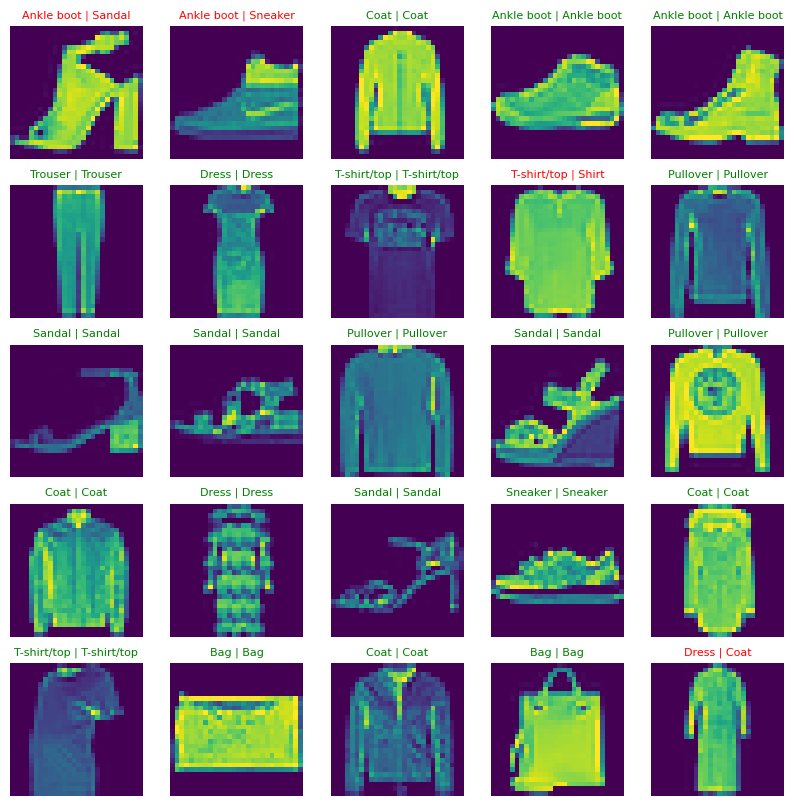

In [96]:
def show_grid(row , col , model  , Cnn = 0):
  fig = plt.figure(figsize = (row*2 , col*2))
  correct_count = 0
  for i in range(1, row*col +1 ):
    fig.add_subplot(row ,col , i)
    rndIdx = torch.randint(0,len(test_data) , size = [1]).item()
    img , label = test_data[rndIdx]

    if(not Cnn): pred = model.pred(img).argmax(dim=1).item()
    else: pred = model.pred(img.unsqueeze(dim=1)).item()
    correct = (pred == label)
    correct_count+= correct

    plt.title(f"{classNames[pred]} | {classNames[label]}" , c = "green" if correct else "red" , fontsize = 8)
    plt.imshow(img.permute(1,2,0))
    plt.axis(False)
  print(f"correct : {correct_count} , Wrong : {row*col - correct_count}")
    #return {"correct" : correct_count , "Wrong" : row*col - correct_count}
show_grid(5,5,model0)

## Model with Activation


In [11]:
class two(nn.Module):
  def __init__(self):
    super().__init__()
    self.seq = nn.Sequential(
        nn.Flatten(),
        nn.ELU(0.9),
        nn.Linear(in_features = 28 * 28 , out_features = 10),
    )

  def forward(self , X):
    return self.seq(X)
  def pred(self , X):
    self.eval()
    with torch.inference_mode():
      return self(X)


In [12]:
model1 = two()
loss_fn = nn.CrossEntropyLoss()

In [13]:
train(model = model1 , lr = 0.1 , epochs = 3, trainDataLoader = trainDataLoader ,
      testDataLoader = testDataLoader , batch_size = 32 , loss_fn = loss_fn)

  0%|          | 0/3 [00:00<?, ?it/s]

seen 0 / 60000
seen 12800 / 60000
seen 25600 / 60000
seen 38400 / 60000
seen 51200 / 60000
epoch 0 | train loss : 3.498747 , test loss : 3.097 | test accuracy 80.790735%
seen 0 / 60000
seen 12800 / 60000
seen 25600 / 60000
seen 38400 / 60000
seen 51200 / 60000
epoch 1 | train loss : 3.481850 , test loss : 4.134 | test accuracy 79.013578%
seen 0 / 60000
seen 12800 / 60000
seen 25600 / 60000
seen 38400 / 60000
seen 51200 / 60000
epoch 2 | train loss : 3.607739 , test loss : 4.943 | test accuracy 74.780351%


correct : 18 , Wrong : 7


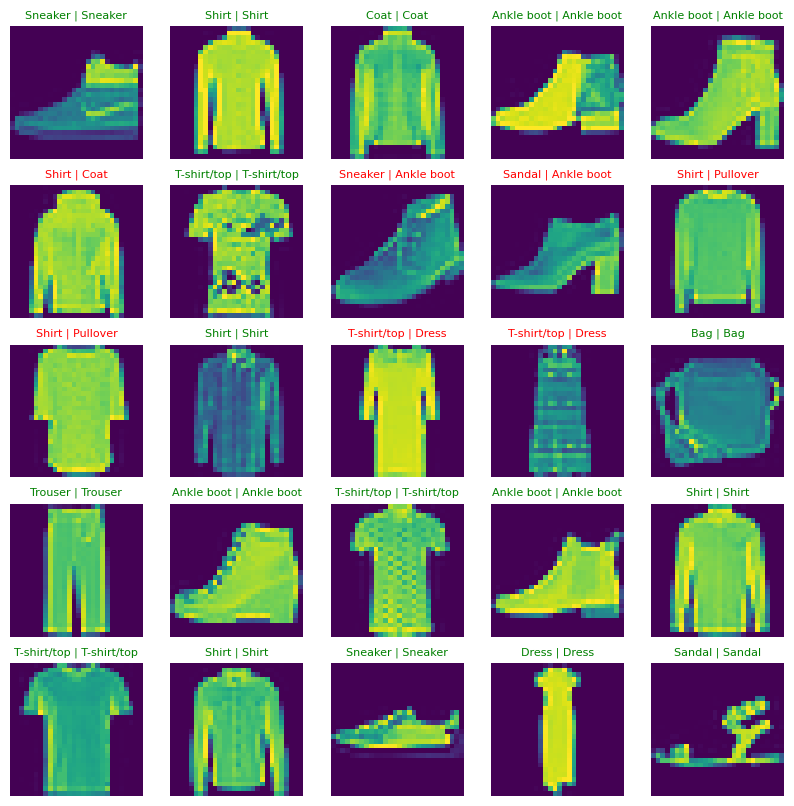

In [14]:
show_grid(5,5,model1)

## CNN Model

In [69]:
class three(nn.Module):
  def __init__(self):
    super().__init__()
    self.block1 = nn.Sequential(
        nn.Conv2d(in_channels = 1 , out_channels = 10 ,
                  kernel_size = (3,3) ,
                  stride = 1 ,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = 10 , out_channels = 10 ,
                  kernel_size = (3,3),
                  stride = 1 ,
                  padding = 1),
        nn.MaxPool2d(kernel_size = (2,2),
                    stride = 2),
    )
    self.block2 = nn.Sequential(
        nn.Conv2d(in_channels = 10  , out_channels = 10 , kernel_size =(3,3) , stride = 1 , padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = 10 , out_channels = 10 , kernel_size =(3,3) , stride = 1 , padding =1 ),
        nn.MaxPool2d(kernel_size = (2,2) , stride = 2)
    )
    self.Classify = nn.Sequential(
        nn.Flatten() ,
        nn.Linear(in_features = 10*7*7 , out_features = 10)

    )
  def forward(self , X):
    X1 = self.block1(X)
    X2 = self.block2(X1)
    y = self.Classify(X2)
    return y
  def pred(self , X):
    self.eval()
    with torch.inference_mode():
      return self(X).argmax(dim=1)

In [70]:
model2 = three()
loss_fn = nn.CrossEntropyLoss()

In [105]:
%%time
train(model = model2 ,  lr = 0.001 , epochs = 3 , batch_size = 32)

  0%|          | 0/3 [00:00<?, ?it/s]

seen 0 / 60000
seen 12800 / 60000
seen 25600 / 60000
seen 38400 / 60000
seen 51200 / 60000
epoch 0 | train loss : 0.250414 , test loss : 0.297 | test accuracy 89.636581%
seen 0 / 60000
seen 12800 / 60000
seen 25600 / 60000
seen 38400 / 60000
seen 51200 / 60000
epoch 1 | train loss : 0.245675 , test loss : 0.295 | test accuracy 89.576677%
seen 0 / 60000
seen 12800 / 60000
seen 25600 / 60000
seen 38400 / 60000
seen 51200 / 60000
epoch 2 | train loss : 0.241877 , test loss : 0.291 | test accuracy 89.756390%
CPU times: user 2min 14s, sys: 315 ms, total: 2min 14s
Wall time: 2min 16s


correct : 22 , Wrong : 3


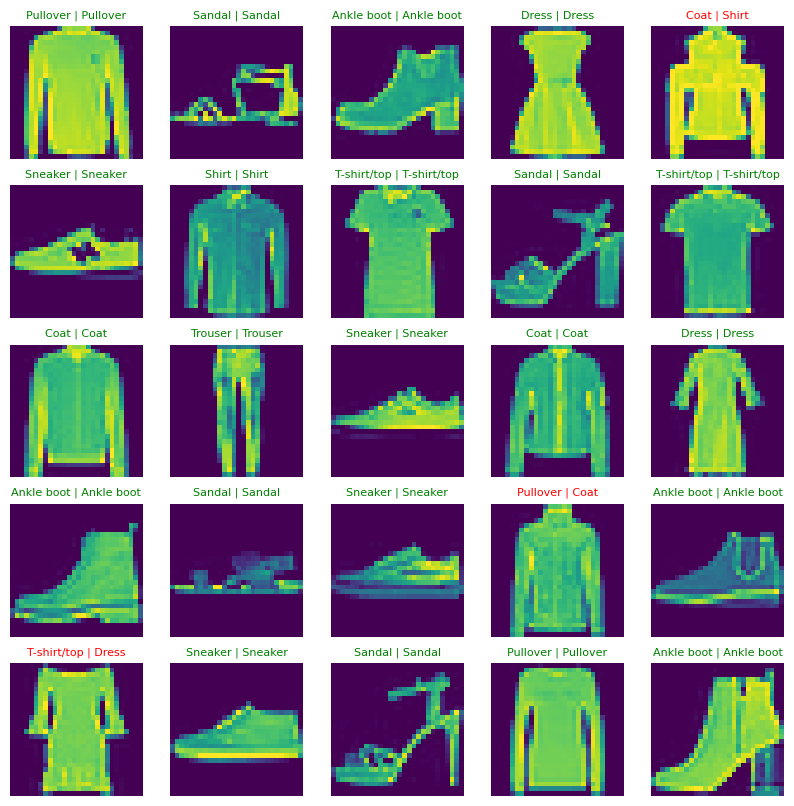

In [101]:
show_grid(5,5,model2 , 1)